In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

sys.path.append("../")

from src.data_processing import DataProcessing
from src.visualization import visualize_transfer_network

pd.options.display.max_columns = 100

# Data Loading and processing


In [45]:
df = pd.read_csv("../data/transfers.csv")
dp = DataProcessing(df)
df = dp.process_data()
df.head(5)

,season,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee,is_loan,same_country
0,2009,3,1017,1. FC Köln,Hapoel Tel Aviv,Germany,Israel,0.0,0.0,False
1,2009,3,113,1. FC Köln,FC Carl Zeiss Jena,Germany,Germany,0.0,1.0,True
2,2009,3,17,1. FC Köln,Borussia Dortmund II,Germany,Germany,0.0,1.0,True
3,2009,3,2113,1. FC Köln,Career break,Germany,Career break,0.0,0.0,False
4,2009,3,3709,1. FC Köln,Getafe CF,Germany,Spain,750000.0,0.0,False


In [46]:
df_season = df[df["season"] == 2020]

In [47]:
di_graph = nx.from_pandas_edgelist(
    df_season,
    source="team_name",
    target="counter_team_name",
    edge_attr=["total_fee", "is_loan", "same_country"],
    create_using=nx.DiGraph,
)
for _, row in df_season.iterrows():
    di_graph.nodes[row["team_name"]]["country"] = row["team_country"]
    di_graph.nodes[row["counter_team_name"]]["country"] = row["counter_team_country"]

# Edge prediction for the directed graph


In [48]:
from src.edge_pred import TransferGraphDataProcessor, TransferEdgePrediction

In [49]:
processor = TransferGraphDataProcessor(di_graph, test_size=0.2)
train_graph, test_edges, test_non_edges = processor.split_edges()

print(
    f"Train graph has {train_graph.number_of_nodes()} nodes and {train_graph.number_of_edges()} edges"
)
print(
    f"Test set has {len(test_edges)} positive edges and {len(test_non_edges)} negative edges"
)

processor.extract_node_features(method="both")
X_train, y_train, X_test, y_test, feature_names = processor.prepare_training_data()

Train graph has 1082 nodes and 2765 edges
Test set has 692 positive edges and 692 negative edges


Computing transition probabilities:   0%|          | 0/1082 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 124.08it/s]


Generating negative examples for training...
Train w/ 2765 positive, 2765 neg
Preparing training data...


100%|██████████| 2765/2765 [00:17<00:00, 157.34it/s]


Preparing test data...


100%|██████████| 692/692 [00:04<00:00, 151.78it/s]


In [50]:
# Train and evaluate edge prediction models
predictor = TransferEdgePrediction()
predictor.train_models(X_train, y_train, feature_names)

# Evaluate models
results = predictor.evaluate_models(X_test, y_test)
print("Model evaluation results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Training models with hyperparameter tuning...
Model evaluation results:

logistic_regression:
  accuracy: 0.8678
  precision: 0.8921
  recall: 0.8367
  f1: 0.8635
  roc_auc: 0.9544

random_forest:
  accuracy: 0.8092
  precision: 0.8664
  recall: 0.7312
  f1: 0.7931
  roc_auc: 0.9379

gradient_boosting:
  accuracy: 0.8085
  precision: 0.8779
  recall: 0.7168
  f1: 0.7892
  roc_auc: 0.9397


In [57]:
# Get node pairs to predict
node_pairs = processor.sample_node_pairs_for_prediction(sample_size=1000)

# Predict top potential transfers
top_transfers = predictor.predict_top_edges(
    node_pairs, processor, top_k=5, model_name="logistic_regression"
)
print("\nTop 5 predicted transfers:")
for u, v, prob in top_transfers:
    print(f"{u} -> {v}: {prob:.4f}")

Predicting edge probabilities...


100%|██████████| 1000/1000 [00:06<00:00, 145.51it/s]


Top 5 predicted transfers:
Atalanta BC -> Castelvetro Calcio: 0.9958
Genoa CFC -> FC Arouca: 0.9951
KAA Gent -> Real Madrid: 0.9942
AS Monaco -> Sporting Gijón: 0.9931
ACF Fiorentina -> CD Lugo: 0.9930


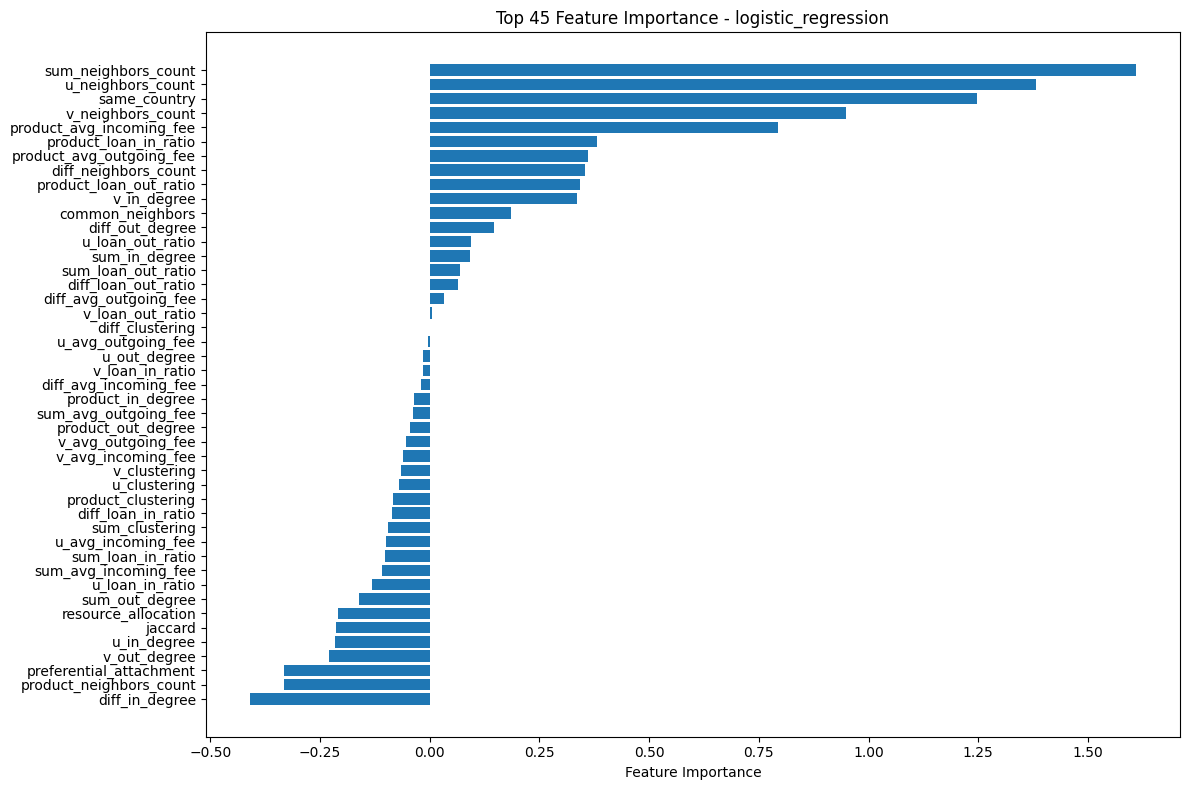

In [52]:
predictor.plot_feature_importance("logistic_regression")

# Prediction for next season


In [53]:
df_next_season = df[df["season"] == 2021]

In [ ]:
predictions_acc = []

for u, v, prob in top_transfers:
    if (
        u in df_next_season["team_name"].values
        and v in df_next_season["counter_team_name"].values
    ):
        predictions_acc.append((u, v, prob, 1))
        print(f"Transfer {u} to {v} occurred in the next season.")
    else:
        predictions_acc.append((u, v, prob, 0))
        print(f"Transfer {u} to {v} did not occur in the next season.")

Transfer Atalanta BC to Castelvetro Calcio did not occur in the next season.
Transfer Genoa CFC to FC Arouca occurred in the next season.
Transfer KAA Gent to Real Madrid occurred in the next season.
Transfer AS Monaco to Sporting Gijón occurred in the next season.
Transfer ACF Fiorentina to CD Lugo occurred in the next season.


In [ ]:
top_transfers = predictor.predict_top_edges(
    node_pairs, processor, top_k=-1, model_name="logistic_regression"
)

for u, v, prob in top_transfers:
    if (
        u in df_next_season["team_name"].values
        and v in df_next_season["counter_team_name"].values
    ):
        predictions_acc.append((u, v, prob, 1))
    else:
        predictions_acc.append((u, v, prob, 0))

Predicting edge probabilities...


100%|██████████| 1000/1000 [00:06<00:00, 146.50it/s]


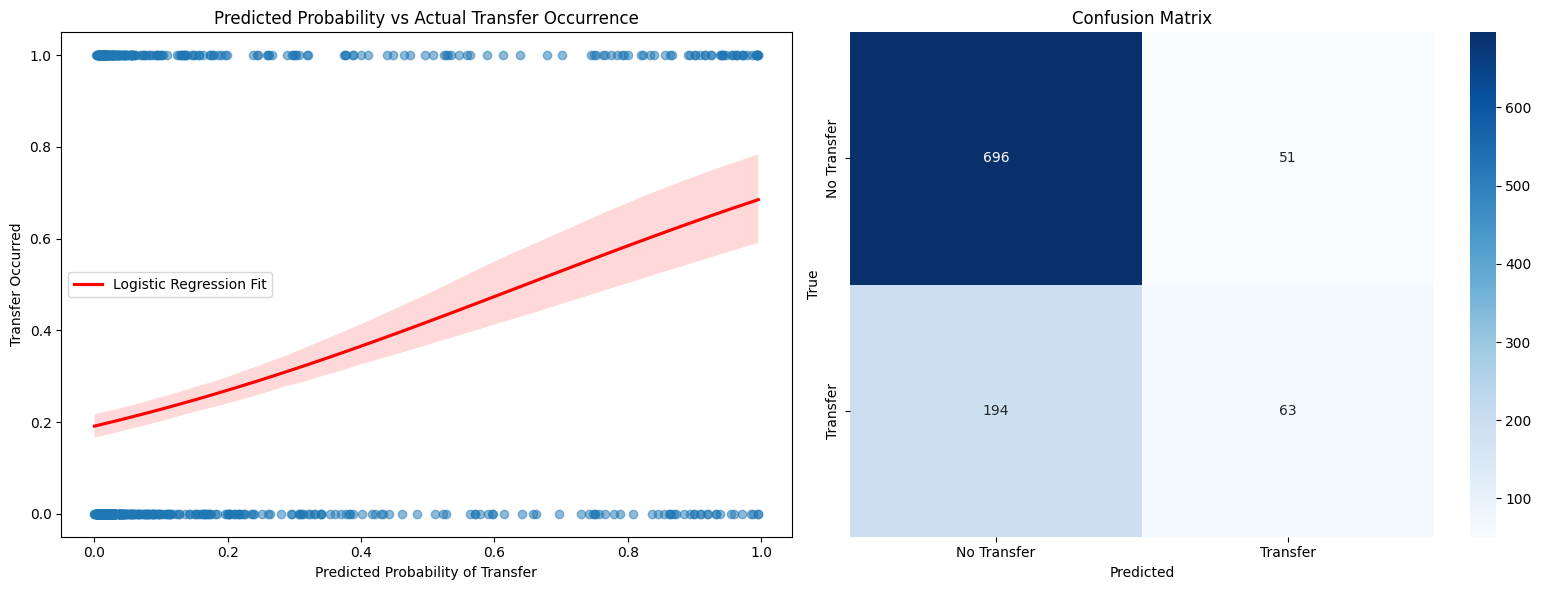

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming predictions_acc is already defined
predictions_acc_df = pd.DataFrame(
    predictions_acc,
    columns=["team_name", "counter_team_name", "probability", "occurred"],
)

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Logistic regression fit
sns.regplot(
    data=predictions_acc_df,
    x="probability",
    y="occurred",
    logistic=True,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red", "label": "Logistic Regression Fit"},
    ax=axs[0],
)
axs[0].set_xlabel("Predicted Probability of Transfer")
axs[0].set_ylabel("Transfer Occurred")
axs[0].set_title("Predicted Probability vs Actual Transfer Occurrence")
axs[0].legend(loc="center left")

# Plot 2: Confusion matrix
cm = confusion_matrix(
    predictions_acc_df["occurred"], predictions_acc_df["probability"].round()
)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Transfer", "Transfer"],
    yticklabels=["No Transfer", "Transfer"],
    ax=axs[1],
)
axs[1].set_title("Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.show()